# eCommerce Analysis

This analysis was conducted to familiarize myself with basis data cleaning and manipulation using pandas, and graph generation using ggplot in Python.





### Dataset Description

The dataset was obtained from UCI Machine Learning database, specifically, the data was donated by:
_Dr. Daqing Chen, Course Director: MSc Data Science. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK._

The dataset contains online sales transaction for a UK-based retail store between Dec. 1, 2009 and Dec 9, 2011. The main type of items is giftware.

## Some Guiding Questions

1. Which products are selling the msot on the website?
2. Which months and what times of the day are there most traffic of transactions?
3. Who are the best customers, and who are the worst customers?
4. Which customers are likely to contribute the most revenue in the future?


### Main Learning Objectives

1. Review pandas basic data wrangling features
2. Familiarize myself with ggplot implementation in python through plotnine
3. Familiarize myself with lifetimes package for online transactional analytics


## I. Data Cleaning and Preparation

In [1]:
import glob
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from plotnine import *

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, accuracy_score

import xgboost as xgb

In [2]:
def get_data():
    csv_files = glob.glob('*.csv')
    list_data = []
    
    for filename in csv_files:
        data = pd.read_csv(filename, encoding = "ISO-8859-1")
        list_data.append(data)
        
    raw_data = pd.concat(list_data)
    
    print("A total of %s files were imported, the final dataframe has %s rows and %s columns" % (len(list_data), raw_data.shape[0], raw_data.shape[1]))
    return raw_data

data = get_data()

A total of 2 files were imported, the final dataframe has 1067371 rows and 8 columns


In [3]:
def clean(data):
    ## Figure out which orders are cancelled, and label them
    cancelled = data.apply(lambda x: True if x['Quantity'] <= 0 else False, axis=1)
    ## Count number of cancelled orders
    total_number = len(data)
    cancelled_number = sum(cancelled*1)
    percentage_cancelled = round(100*(cancelled_number/total_number), 2)
    ## Drop cancelled orders, then check that there is still enough data
    data = data.drop(cancelled[cancelled == True].index)
    ## There are lots of orders with missing customer IDs - these are removed as well
    data = data.loc[data['Customer ID'].notna()]    
    ## Assign datatypes for further analysis
    data['Customer ID'] = data['Customer ID'].astype(int)
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], infer_datetime_format=True)
    ## Drop duplicates
    data = data.drop_duplicates(keep = 'first')
    
    print("There is a total of %s orders, %s of which are cancelled and dropped. Cancelled orders constitute %s percent of the total orders" %
          (total_number, cancelled_number, percentage_cancelled))
    
    return data

data = clean(data)

There is a total of 1067371 orders, 22950 of which are cancelled and dropped. Cancelled orders constitute 2.15 percent of the total orders


In [4]:
def prep_invoice(data):
    ## Prepare additional columns for date and time
    invoice_table = data.copy()
    invoice_table['Month'] = invoice_table['InvoiceDate'].dt.month 
    invoice_table['Year_Month'] = invoice_table['InvoiceDate'].dt.to_period('M')
    invoice_table['Weekday'] = invoice_table['InvoiceDate'].dt.dayofweek
    invoice_table['Weekday'].replace({0: 'Monday',
                                      1: 'Tuesday',
                                      2: 'Wednesday',
                                      3: 'Thursday',
                                      4: 'Friday',
                                      5: 'Saturday',
                                      6: 'Sunday'}, inplace=True)
    invoice_table['Time'] = invoice_table['InvoiceDate'].dt.hour // 6
    invoice_table['Time'].replace({0: 'Night',
                                      1: 'Morning',
                                      2: 'Afternoon',
                                      3: 'Evening'}, inplace=True)
    #invoice_table['InvoiceDate'] = invoice_table['InvoiceDate'].dt.date
    ## Prepare a column to indicate if purchase was made in the UK    
    invoice_table['UK?']=invoice_table['Country'].apply(lambda x: 'UK' if x == 'United Kingdom' else 'Non-UK')
    ## Prepare a column to calculate value of each invoice entry    
    invoice_table['Value']=invoice_table['Price'] * invoice_table['Quantity']
    invoice_table = invoice_table.groupby(['Invoice', 'Customer ID', 'InvoiceDate','Year_Month','Month','Weekday','Time','UK?'], as_index = False).agg({'Value': 'sum', 'StockCode':'count'})
    invoice_table = invoice_table.loc[invoice_table['Value']>=0]
    invoice_table = invoice_table.rename(columns = {'StockCode':'Unique_Items'})
    
    return invoice_table

invoice_table = prep_invoice(data)

In [5]:
invoice_table.sample(5)

,Invoice,Customer ID,InvoiceDate,Year_Month,Month,Weekday,Time,UK?,Value,Unique_Items
13976,525440,13777,2010-10-05 13:37:00,2010-10,10,Tuesday,Afternoon,UK,677.00,4
13894,525260,13021,2010-10-04 15:41:00,2010-10,10,Monday,Afternoon,UK,448.10,23
17934,535258,16612,2010-11-25 13:14:00,2010-11,11,Thursday,Afternoon,UK,306.60,16
10229,516493,18061,2010-07-21 10:39:00,2010-07,7,Wednesday,Morning,UK,176.28,4
30456,566606,15194,2011-09-13 16:33:00,2011-09,9,Tuesday,Afternoon,UK,305.37,20


The original dataframe contained one unique item per row. The cleaned table provides invoice-level information and are ready to be explored on various time-scale.

## II. Basic Summary Statistics

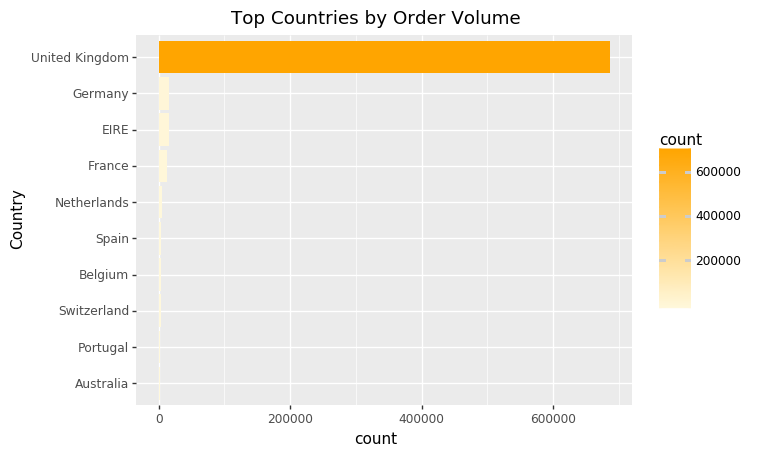

<ggplot: (-9223371923467745434)>

In [6]:
## Top 10 Markets shopping on the website - UK is evidently the main market
top_countries = pd.DataFrame(data['Country'].value_counts().head(10)).reset_index()
top_countries = top_countries.rename(columns={"index": "Country",
                                      "Country": "count"})
country_list = top_countries['Country'].tolist()
country_list.reverse()

ggplot(top_countries) + aes('Country', 'count', fill = 'count') +\
geom_bar(stat = 'identity') +\
ggtitle("Top Countries by Order Volume")+\
scale_x_discrete(limits=country_list) +\
scale_fill_gradient(low = "cornsilk", high  = "orange")+\
coord_flip()

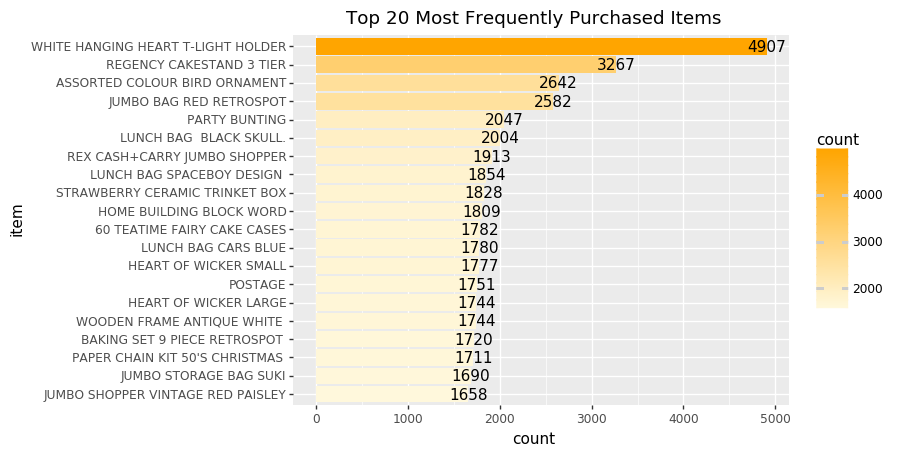

<ggplot: (113387803298)>

In [7]:
## Top 20 items purchased most frequently
top_items = pd.DataFrame(data['Description'].value_counts().head(20)).reset_index()
top_items = top_items.rename(columns={"index": "item",
                                      "Description": "count"})
items_list = top_items['item'].tolist()
items_list.reverse()

ggplot(top_items) + aes('item', 'count', fill = 'count', label = 'count') +\
geom_bar(stat = 'identity') +\
geom_text()+\
ggtitle("Top 20 Most Frequently Purchased Items")+\
scale_x_discrete(limits=items_list) +\
scale_fill_gradient(low = "cornsilk", high  = "orange")+\
coord_flip()


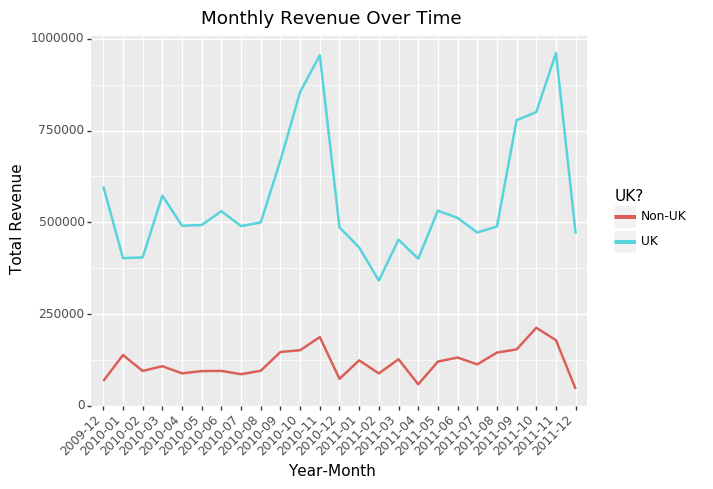

<ggplot: (-9223371923466967278)>

In [8]:
## Graph Revenue seasonality by month and country
month_table = invoice_table.groupby(['Year_Month', 'UK?'], as_index=False).agg({'Value':'sum',
                                   'Invoice': 'count'})
month_table['Avg Order Rev'] = month_table['Value']/month_table['Invoice']

## Monthly Revenue over time shows that UK revenue experiences higher seasonality changes than non-UK orders
ggplot(month_table) +\
geom_line(aes(x = 'Year_Month', y = 'Value', group = 'UK?', color = 'UK?'), size = 1) +\
ggtitle("Monthly Revenue Over Time") +\
theme(axis_text_x = element_text(angle=45, hjust=1))+\
labs(y = 'Total Revenue', x = 'Year-Month')

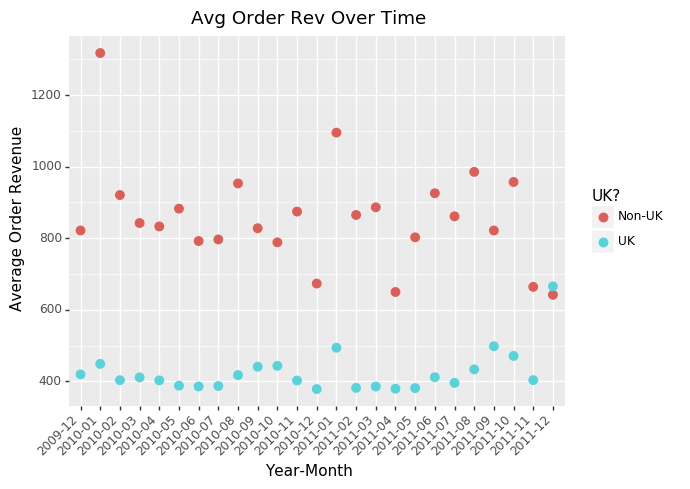

<ggplot: (113387985216)>

In [9]:
## Explore the seasonality in average order revenue by country
ggplot(month_table) +\
geom_point(aes(x = 'Year_Month', y = 'Avg Order Rev', group = 'UK?', color = 'UK?'), size = 3) +\
ggtitle("Avg Order Rev Over Time") +\
theme(axis_text_x = element_text(angle=45, hjust=1))+\
labs(y = 'Average Order Revenue', x = 'Year-Month')

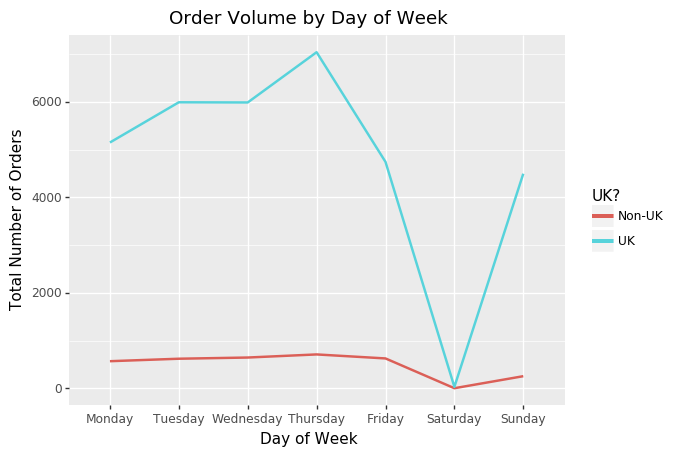

<ggplot: (-9223371923466790512)>

In [10]:
## Investigate transaction traffic over day of the week
DOW_table = invoice_table.groupby(['Weekday', 'UK?'], as_index=False).agg({'Value':'sum',
                                   'Invoice': 'count'})
ggplot(DOW_table) +\
geom_line(aes(x = 'Weekday', y = 'Invoice', group = 'UK?', color = 'UK?'), size = 1) +\
ggtitle("Order Volume by Day of Week") +\
scale_x_discrete(limits=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])+\
labs(y = 'Total Number of Orders', x = 'Day of Week')

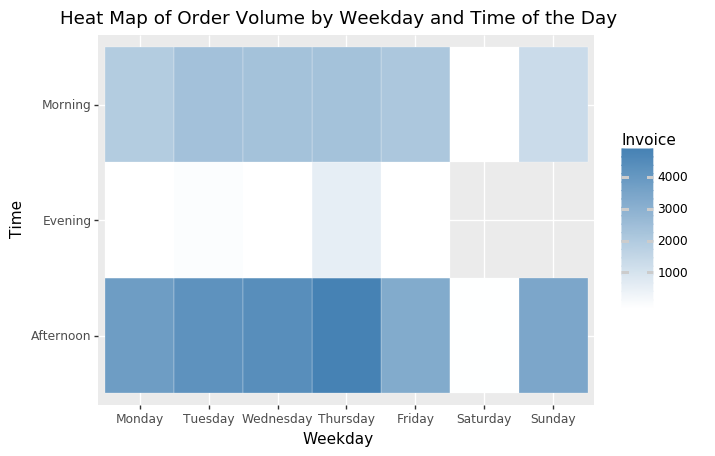

<ggplot: (113387228336)>

In [11]:
## Investigate the time for highest 
TOD_table = invoice_table.groupby(['Weekday','Time'], as_index=False).agg({'Value':'sum',
                                   'Invoice': 'count'})
ggplot(TOD_table) +\
geom_tile(aes(x = 'Weekday', y = 'Time', fill = 'Invoice'),colour = 'white') +\
scale_x_discrete(limits=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])+\
ggtitle("Heat Map of Order Volume by Weekday and Time of the Day") +\
scale_fill_gradient(low = 'white',high='steelblue')

A few insights from these summaries:

1. Despite being an international firm, most of the customers are from the UK
2. Peak season of sales occurs between October and December of every year (not surprising), especially for the UK-based customers
3. Despite that UK-customers contribute to a higher overall revenue, non-UK customers (on average) places orders with higher revenues compared to the UK-customers
4. Transactions experience a spike on Wednesdays, and is extremely low on Saturdays 
5. Most orders appear to be placed in the afternoon, and almost no orders are placed in the evenings. This aligns with the dataset description that the eCommerce company mostly serves wholesalers

## III. Prediction of Customer Spending Using RFM Scores

This analysis was inspired by the Baris Karaman's "Customer Life Time Value" post on Towards Data Science. The goal is to predict a customer's total spending in a given time period using the Recency, Frequency, and Monetary metrics as predictors. The current approach uses the spending in the last 3 months of data (Sept - Dec, 2011) as the target variable, and builds RFM scores based on the spending patterns in the past (Dec, 2009 - Aug, 2011).


### Create RFM Scores

In [12]:
## Split data to off-set last quarter of sales revenue as the target variable
target_period = invoice_table.loc[invoice_table['Year_Month'] >= '2011-09']
train_period = invoice_table.loc[invoice_table['Year_Month'] < '2011-09']
present_date = dt.datetime(2011, 8, 31)
customer_table = train_period.groupby('Customer ID', as_index = False)\
        .agg({'InvoiceDate': lambda date: (present_date-date.max()).days,
              'Invoice': 'count',
              'Value': 'mean'})
customer_table = customer_table.rename(columns={
            'InvoiceDate': 'Recency',
            'Invoice': 'Frequency',
            'Value': 'Monetary'})
customer_table.sample(5)

,Customer ID,Recency,Frequency,Monetary
1312,13862,7,7,301.861429
51,12402,222,5,207.400000
4207,17122,18,4,142.625000
2445,15124,90,3,119.126667
1284,13827,32,2,150.380000


In [13]:
## Define function to order clusters
def Order_Cluster(table, cluster_name, metric_name, ascending = True):
    temp = customer_table.groupby([cluster_name], as_index = False).agg({metric_name:'mean'})
    temp = temp.sort_values(by=metric_name,ascending=ascending).reset_index(drop=True)
    temp['index'] = temp.index
    new_table = table.merge(temp[[cluster_name, 'index']], on = cluster_name)
    new_table = new_table.drop([cluster_name],axis=1)
    new_table = new_table.rename(columns={"index":cluster_name})
    return new_table   

In [14]:
## Use kmeans clustering to put each customer into RFM buckets
kmeans = KMeans(n_clusters=4)
kmeans.fit(customer_table[['Recency']])
customer_table['Recency_Score'] = kmeans.predict(customer_table[['Recency']])
## Order Clusters according to Recency logic (lower recency = higher score)
customer_table = Order_Cluster(customer_table, 'Recency_Score', 'Recency',ascending = False)
## Create Frequency Clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(customer_table[['Frequency']])
customer_table['Frequency_Score'] = kmeans.predict(customer_table[['Frequency']])
## Order Clusters according to Frequency logic (higher frequency = higher score)
customer_table = Order_Cluster(customer_table, 'Frequency_Score', 'Frequency',ascending = True)
## Create Monetary Clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(customer_table[['Monetary']])
customer_table['Monetary_Score'] = kmeans.predict(customer_table[['Monetary']])
## Order Clusters according to Monetary logic (higher Monetary value = higher score)
customer_table = Order_Cluster(customer_table, 'Monetary_Score', 'Monetary',ascending = True)
    
## Create Overall RFM Scoring Column
customer_table['RFM_Score'] = customer_table['Recency_Score']+customer_table['Frequency_Score']+customer_table['Monetary_Score']

## Generate Target Variable
temp = target_period.groupby('Customer ID', as_index = False).agg({'Value':'sum'})
customer_table = customer_table.merge(temp, on ='Customer ID')

C:\Users\tsaof\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 40'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)
C:\Users\tsaof\Anaconda3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 63 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\tsaof\Anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


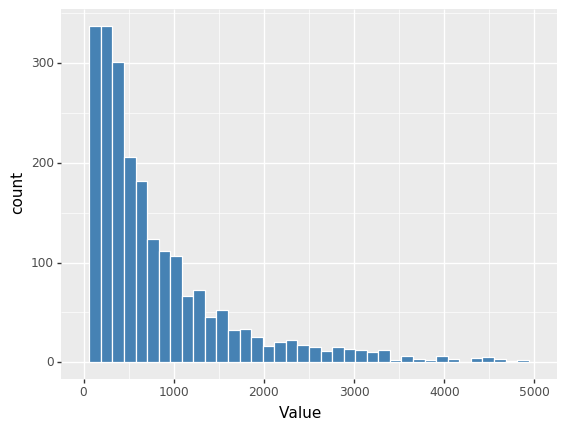

<ggplot: (-9223371923466889991)>

In [15]:
ggplot(customer_table, aes(x='Value')) + \
geom_histogram(fill = 'steelblue', colour = 'white')+ \
xlim(0,5000)


### Assign Revenue Buckets

After playing with the dataset a few times, it turns out there are a few extremely high-value invoices that end up skewing the model a lot when assigning revenue groups as the target variable. The rest of the analysis was thus conducted using a subset of the data to mitigate this. In reality, one should probably set a threshold of RFM to filter the data with. 

In [16]:
customer_table = customer_table.loc[customer_table['Value']<3000]

C:\Users\tsaof\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


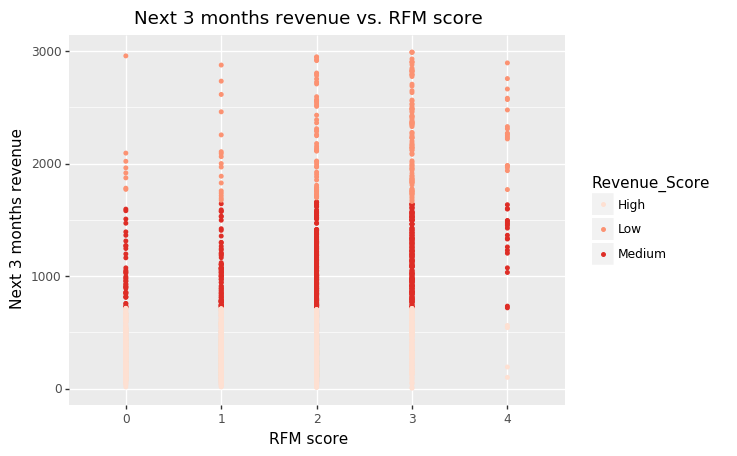

<ggplot: (113387547326)>

In [17]:
## Create Revenue Labels
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_table[['Value']])
customer_table['Revenue_Score'] = kmeans.predict(customer_table[['Value']])
## Order Clusters according to Monetary logic (higher Value = higher score)
customer_table = Order_Cluster(customer_table, 'Revenue_Score', 'Value',ascending = False)
customer_table['Revenue_Score'].replace({0: 'Low',
                                      1: 'Medium',
                                      2: 'High'}, inplace=True)
## Explore the seasonality in average order revenue by country
(ggplot(customer_table) +\
geom_point(aes(x = 'RFM_Score', y = 'Value', colour = 'Revenue_Score'), size = 1) +\
scale_colour_brewer(type = "seq",palette = 'Reds') +\
ggtitle("Next 3 months revenue vs. RFM score") +\
scale_x_discrete(limits=list(range(0,5)))+\
labs(y = 'Next 3 months revenue', x = 'RFM score'))


In [18]:
customer_table['Revenue_Score'].value_counts()

High      1419
Medium     585
Low        200
Name: Revenue_Score, dtype: int64

The filtered data is now more balanced between the three classes, and XGBoost will be used for this classification problem.

### Multiclass Prediction Using XGBoost

In [19]:
## Convert class lables back to numbers
customer_table['Revenue_Score'].replace({'Low': 0,
                                      'Medium': 1,
                                      'High': 2}, inplace=True)


## Prediction model using 80/20 customer split and set up xgb datasets

target = 'Revenue_Score'
predictors = ['Recency_Score','Frequency_Score', 'Monetary_Score']

train, test = train_test_split(customer_table, test_size=0.2, random_state=123)

train_data = xgb.DMatrix(train[predictors], label=train[target])
test_data = xgb.DMatrix(test[predictors], label=test[target])



C:\Users\tsaof\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\tsaof\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [20]:
## Set up randomized search for best parameters

params = {'n_estimators': [50, 100, 150, 200],
          'eta': [0.01, 0.1, 0.5, 1],
          'max_depth': [3, 5, 7, 9]}

num_round = 20
xgb = xgb.XGBClassifier(random_state = 123,objective= 'multi:softprob', num_class= 3,)
xgb_cv = RandomizedSearchCV(xgb, param_distributions = params, 
                            n_iter = 10,
                            verbose = 0,
                            random_state = 2,
                            cv = 3)
xgb_cv.fit(train[predictors],train[target])
best_score = round(100*(xgb_cv.best_score_),2)

print('The overall train accuracy is %s' %(best_score))


The overall train accuracy is 68.01


In [21]:
## Use best model to make predictions on the test data

optimal_xgb = xgb_cv.estimator
optimal_xgb.fit(train[predictors], train[target])
predictions = optimal_xgb.predict(test[predictors])

test_score = round(100*(accuracy_score(test[target], predictions)),2)

print('The overall test accuracy is %s' %(test_score))

The overall test accuracy is 66.44


At first glance, 65% accuracy seems alright. But consindering that 64% of the dataset belongs to one class, this is not that good of an improvement from the naive guess. Moreover, while the above approach is a quick and simple way to get a forecast of a customer's spending in the next time period (next quarter in this case), I am not sure if this method gives enough insights for a company to act on, or if it is a realistic approach. 

There are a few drawbacks from the above approach, some of which include
1. It does not tell a firm about the timing of a customer's purchase
2. Customers are assumed to not drop out (ie, all customers are all "alive" and active)
3. It only predicts for the customers' revenue bucket for the specified future time frame - this doesn't help in estimating the overall life time value of a customer



## IV. Modeling Customer Lifetime Value and Purchase Timing

Because of the unsatisfactory results from the last section, I looked into other models that more realistically reflect customers' purchasing behaviour, and came across the lifetimes package developed by Cameron Davidson-Pilon from Shopify. Much of the analysis in the next section are taken straight out of the amazing documenation of this package. 


Some notes on terminology for my future self:

__1. Frequency:__ the number of _repeat_ purchases of a customer (ie total number of purchases - 1)

__2. Recency:__"age" of the customer given a time unit (ie today - first instance of purchase)

__3. T:__ Recency: same as before - today - last instance of purchase

In [22]:
## Import the necessary functions
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter

### Getting RFM metrics

In [23]:
## Summarize frequency data directly from invoice-level data

lt_df = summary_data_from_transaction_data(invoice_table, 'Customer ID', 'InvoiceDate', monetary_value_col='Value', observation_period_end='2011-12-9')
lt_df.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,7.0,400.0,725.0,11066.637143
12347,7.0,402.0,404.0,576.425714
12348,4.0,363.0,438.0,439.310000
12349,3.0,571.0,589.0,1104.096667
12350,0.0,0.0,310.0,0.000000


### Analysis of Frequency and Recency using BG/NBD

Reference:  Fader et al. (2005) “Counting Your Customers” the Easy Way: An Alternative to the Pareto/NBD Mode"  

This model is used to find the expected repeat transactions for customers, whether he/she churns, and what the LTV is.

Key model assumptions are:

1. Any active customer's transactions in time period (t) follows a Poisson distribution 

2. The distribution of transaction rate of different customers follow a gamma distribution 

3. There is a finite probability (p) that a customer becomes inactive after each trasaction

4. The distribution of p follows a beta distribution

5. The variation of p and transaction rate between customers are independent



In [24]:
bgf = BetaGeoFitter(penalizer_coef=0.0)

bgf.fit(lt_df['frequency'],lt_df['recency'],lt_df['T'])

<lifetimes.BetaGeoFitter: fitted with 5873 subjects, a: 0.11, alpha: 63.39, b: 2.42, r: 0.66>

In [25]:
## Not related - just playing with default colour schemes of matplotlib
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


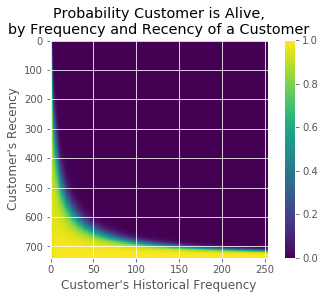

In [26]:
## Visualization of recency and frequency to see if a customer is "alive"
plt.style.use('ggplot')
plot_probability_alive_matrix(bgf)

The graph shows that customers with less than 250 times in frequency, and less than 100 in recent purchase are most likely to be "alive". This is good, but now we can also rank customers from highest lowest in terms the expected purchase in the next time period (t). t can be customized depending on the purpose of the project. Here I will use t = 7, ie the expected purchase in the coming week. This value is given as the "expected number of purchase", NOT the monetary value. This model assumes that the customers that will be making the most purchae in the next period are the same best customers in the current moment.

In [27]:
t = 7
lt_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, lt_df['frequency'], lt_df['recency'], lt_df['T'])
lt_df.sort_values(by='predicted_purchases', ascending = False).head(5)

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
14911,253.0,737.0,738.0,1127.646601,2.213370
12748,201.0,735.0,735.0,256.169502,1.766333
15311,194.0,738.0,738.0,579.735928,1.698609
17841,192.0,736.0,737.0,347.447396,1.682991
14606,180.0,735.0,736.0,160.971722,1.580082


The lifetimes package also allows you to easily plot and assess model fit easily

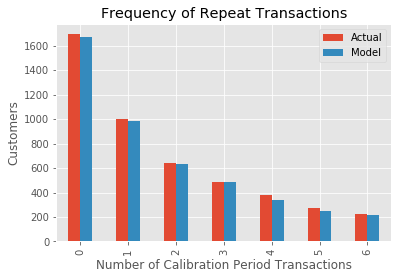

In [28]:
plot_period_transactions(bgf)

In reality, this model would need to be evaluated using a holdout set, which can also be accomplished using the same package by specifying the cutoff time point.

### Estimate LTV using gamma-gamma model

Reference:  Fader and Hardie (2013) “The Gamma-Gamma Model of Monetary Value"    

This model is used to predict the expected amount of spending for a customer.

Key model assumptions are:

1. The monetary value of a customer's transaction varies randomly around their average transaction value

2. Average transaction values vary across customers but do not vary over time for a given individual

3. The distribution of average transaction values across customers is independent of each other and transaction process

In [29]:
## Filter to include only customers who have repeated trnasactions

lt_df = lt_df.loc[lt_df['frequency']>0]

In [30]:
## Fit model
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(lt_df['frequency'],
        lt_df['monetary_value'])
## Create column to include the calculated revenue
lt_df['expected revenue'] = ggf.conditional_expected_average_profit(
        lt_df['frequency'],
        lt_df['monetary_value'])

In [31]:
## Rank by highest next purchase
lt_df.sort_values(by='expected revenue', ascending = False).head(5)

,frequency,recency,T,monetary_value,predicted_purchases,expected revenue
Customer ID,,,,,,
15749,1.0,97.0,332.0,21535.900000,0.024498,9977.112523
12346,7.0,400.0,725.0,11066.637143,0.038745,9497.932423
18102,66.0,738.0,738.0,8664.409091,0.581085,8515.973248
17450,30.0,430.0,438.0,6837.314333,0.425377,6588.245217
13902,4.0,92.0,724.0,8106.950000,0.001045,6319.848183
